In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2a441097cd0>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [10]:
Station_first = session.query(Station).first()
Station_first.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2a4410ae430>,
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US'}

In [11]:
for row in session.query(Measurement.date).limit(15).all():
    print(row)

('2010-01-01',)
('2010-01-02',)
('2010-01-03',)
('2010-01-04',)
('2010-01-06',)
('2010-01-07',)
('2010-01-08',)
('2010-01-09',)
('2010-01-10',)
('2010-01-11',)
('2010-01-12',)
('2010-01-14',)
('2010-01-15',)
('2010-01-16',)
('2010-01-17',)


In [12]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_prior = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#print("Year Prior: ", year_prior)

# Perform a query to retrieve the date and precipitation scores
year_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_prior).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(year_data, columns=['Date', 'Precipitation'])
measurement_df

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22
...,...,...
2218,2017-08-22,0.50
2219,2017-08-23,0.00
2220,2017-08-23,0.00
2221,2017-08-23,0.08


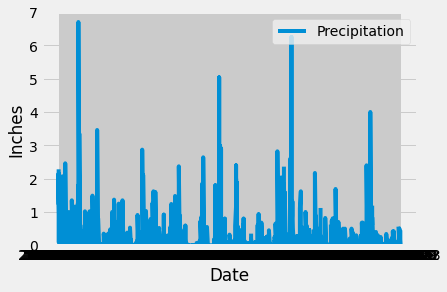

In [42]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(measurement_df['Date'], measurement_df['Precipitation'], label='Precipitation')
#plt.title("Daily Precipitation at All Stations")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(loc="upper right")
plt.ylim(0, 7)


plt.savefig("DailyPrecipBar.png")
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [29]:
# Design a query to calculate the total number stations in the dataset 
stations = session.query(Measurement).group_by(Measurement.station).count()
print(stations)

9


In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

station_count_df = pd.DataFrame(station_counts, columns=['Station', 'Count'])
station_count_df

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [21]:
most_active = station_count_df.max()
most_active

Station    USC00519523
Count             2772
dtype: object

In [22]:
# Using the most active station id from the previous query, calculate:
#   the lowest, highest, and average temperature.
temp = session.query(Measurement.station, Measurement.tobs).\
                    filter(Measurement.station == 'USC00519523').all()
temp_df = pd.DataFrame(temp, columns=['Station', 'Temp'])
temp_df

,Station,Temp
0,USC00519523,75.0
1,USC00519523,75.0
2,USC00519523,77.0
3,USC00519523,75.0
4,USC00519523,75.0
...,...,...
2664,USC00519523,83.0
2665,USC00519523,85.0
2666,USC00519523,82.0
2667,USC00519523,82.0


In [23]:
temp_df.min()

Station    USC00519523
Temp                56
dtype: object

In [24]:
temp_df.max()

Station    USC00519523
Temp                85
dtype: object

In [25]:
temp_df.mean()

Temp    74.543649
dtype: float64

In [26]:
# Using the most active station id query the last 12 months of temperature observation 
 # data for this station 
year_temp_data = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
    filter(Measurement.date > year_prior).\
    filter(Measurement.station == 'USC00519523').\
    order_by(Measurement.date).all()

# put in data frame
year_temp_df = pd.DataFrame(year_temp_data, columns=['Date', 'Station', 'Temp'])
year_temp_df

,Date,Station,Temp
0,2016-08-24,USC00519523,79.0
1,2016-08-25,USC00519523,80.0
2,2016-08-26,USC00519523,84.0
3,2016-08-27,USC00519523,81.0
4,2016-08-28,USC00519523,80.0
...,...,...,...
331,2017-08-17,USC00519523,83.0
332,2017-08-19,USC00519523,85.0
333,2017-08-21,USC00519523,82.0
334,2017-08-22,USC00519523,82.0


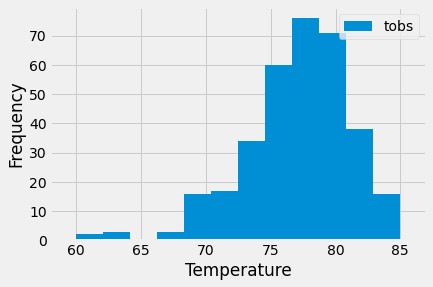

In [40]:
#     and plot the results as a histogram. 
plt.hist(year_temp_df['Temp'], density=False, bins=12, label='tobs')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.xlim(58, 87)
plt.legend(loc="upper right")
plt.savefig("DailyTempBar.png")
plt.show()

# Close session

In [28]:
# Close Session
session.close()